# Fig 3b and data Egill Richard et al 2023-2024

In [1]:
%matplotlib inline
from pylab import *
from sequana import *
from sequana.freebayes_vcf_filter import Variant
import pandas as pd
from collections import Counter

# The data

- EV057-INV_L001.filter.vcf and EVO57-REINV_S4_L001.filter.vcf are the output of the Sequana variant-calling pipeline
- sanger data here below contains the position and frequencies of Sanger sequencing runs (42 samples).
- int1A gene is in the region 1449-2411

In [11]:
# data from 42 PCRs
position_sanger = [57.0, 126.0, 163.0, 172.0, 205.0, 209.0, 227.0, 242.0, 489.0, 500.0, 571.0, 607.0, 669.0, 803.0, 825.0, 829.0, 835.0, 849.0, 860.0]
frequency_sanger = [0.45238095, 0.02380952, 0.02380952, 0.02380952, 0.04761905, 0.02380952, 0.02380952, 0.02380952, 0.02380952, 0.07142857, 0.02380952, 0.02380952, 0.02380952, 0.02380952, 0.02380952, 0.04761905, 0.02380952, 0.02380952, 0.02380952]

In [12]:
vcf_inv = VCF_freebayes("EVO57-INV_L001.filter.vcf")
df = pd.DataFrame([v.resume for v in vcf_inv.get_variants()])
df['position'] = [int(x) for x in df['position']]
df_inv = df

In [13]:
vcf_reinv = VCF_freebayes("EVO57-REINV_S4_L001.filter.vcf")
df = pd.DataFrame([v.resume for v in vcf_reinv.get_variants()])
df['position'] = [int(x) for x in df['position']]
df_reinv = df

In [14]:
# let us check the polyA is found
# This position is important and should be found in vcf_inv (not the reinv) as a INDEL with freq>0.2
assert "AAAAAAA" in df_inv.query("position == 1504").reference.values[0]
df_inv.query("position == 1504")

,chr,position,depth,reference,alternative,type,freebayes_score,strand_balance,fisher_pvalue,frequency,CDS_position,effect_type,codon_change,gene_name,mutation_type,prot_effect,prot_size,effect_impact
277,pJ504,1504,9856,CAAAAAAAAC,CAAAAAAAC; CAAAAAAAAAC; CAAAAAAACC; CAAAAAAAAA,INDEL; INDEL; MNV; MNV,4.567060e-12,0.465; 0.456; 0.375; 0.402,0.47286420464007684; 1.0; 0.0739717857844713; ...,0.219; 0.058; 0.003; 0.012,,,,,,,,MODIFIER


# Utility functions

In [15]:
def get_SNV_INDEL(df, fisher_threshold=0.05):
    """ This function filters the dataframe by keeping SNV and INDEL only

    Moreover, ref to multiple SNV are ignored so A->T and A->C at the same position 
    are ignored. 
    
    If several INDEL, we sum up the frequencies (case of interest is indeed a multiple INDEL.

    we also remove variants with Fisher value below 0.05 (unequal strandness)
    """
    positions = []
    freqs = []
    types = []
    for _, row in df.iterrows():
        row = row.fillna(1000)
        S = 0

        _types = ""
        for _type, freq, fisher in zip(row['type'].split(";"), row.frequency.split(";"), row.fisher_pvalue.split(";")):
            _type = _type.strip()
            if _type in ["INDEL", "SNV"] and float(fisher) > fisher_threshold:
                S += float(freq)
                _types += _type +";"
        # only single SNV and single INDEL and multiple INDEL
        # A -> C is accepted but A->[C, T] is not ; 
        if _types.count(";") == 1 or set([x for x in _types.split(";") if x]) == set(["INDEL"]):
            freqs.append(S)
            positions.append(row.position)
            types.append(_types.strip(";"))
    
    df = pd.DataFrame({"position": positions, "frequency":freqs, "type":types})
    return df

In [8]:
def plot_var(df):
    """This function is used to plot fig3a and c
    
    """
    X = list(range(1449,2411))
    N = []

    for x in X:    
        rows = df.query("position>=@x and position<@x+1")
        freqs = sum([row.frequency for _, row in rows.iterrows()])
        N.append(sum(freqs))
     
    plt.figure(figsize=(8,5))
    bar(X, N, width=10, label="df_inv", zorder=10, color="k")
    ylim([0,0.5])
    _ = xticks([], [])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    yticks([0,0.1,0.2,0.3,0.4,0.5],["0", "0.1", "0.2", "0.3","0.4","0.5" ], fontsize=16)
    xticks([1449, 1449+250, 1449+500, 1449+750, 1449+1000],[], fontsize=16)
    xlim(1449,1449+1002)


# Plot Fig3-a

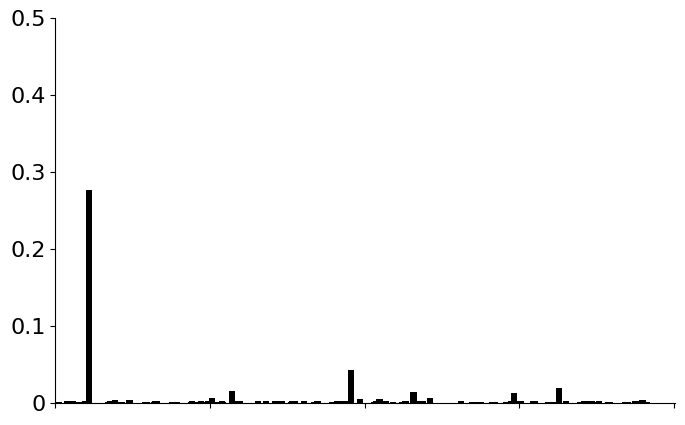

In [16]:
df = get_SNV_INDEL(df_inv).query("position>=1449 and  position<=2411")
plot_var(df)
#text(1700,0.42,"Illumina deep sequencing\n        SCI Inv D7", fontsize=20)

for ext in "png", "pdf", "svg":
    savefig(f"fig3a.{ext}", dpi=200)

# Plot Fig3b

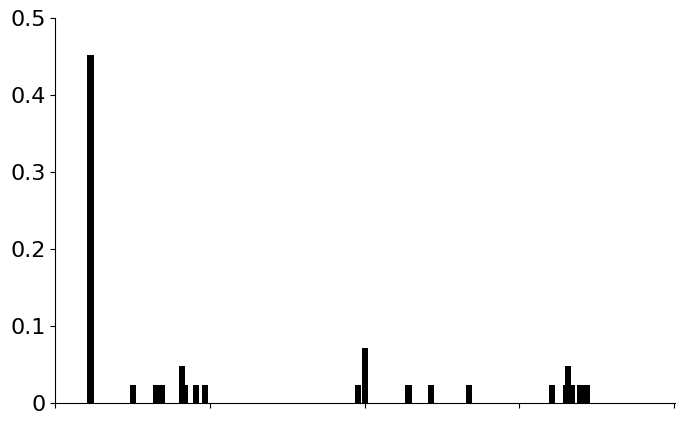

In [21]:
plt.figure(figsize=(8,5))

bar(position_sanger, frequency_sanger, width=10, label="sanger", zorder=10, color='k')
#grid(zorder=-10)

#text(300,0.42,"Sanger sequencing\n        SCI Inv D7", fontsize=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
yticks([0,0.1,0.2,0.3,0.4,0.5],["0", "0.1", "0.2", "0.3", "0.4","0.5" ], fontsize=16)
xticks([0, 250, 500, 750, 1000],[], fontsize=16)
xlim(0,1002)
for ext in "png", "pdf", "svg":
    savefig(f"fig3b.{ext}", dpi=200)

# Plot Fig3c

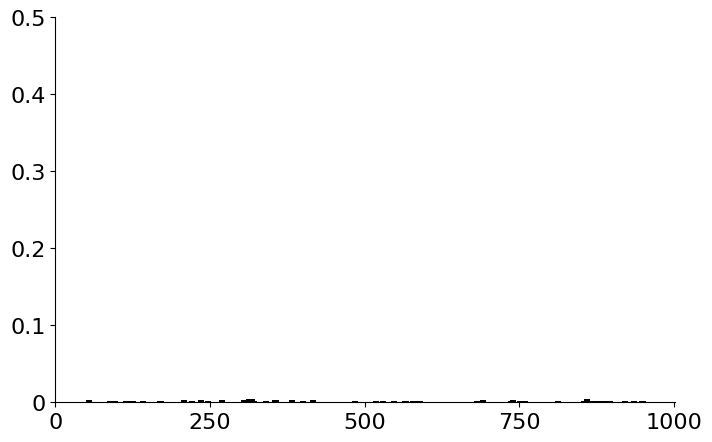

In [20]:
df = get_SNV_INDEL(df_reinv).query("position>=1449 and  position<=2411")
plot_var(df)
#text(1700,0.42,"Illumina deep sequencing\n        SCI Reinv D7", fontsize=20)
xticks([1449, 1449+250, 1449+500, 1449+750, 1449+1000],[0,250,500,750,1000], fontsize=16)
for ext in "png", "pdf", "svg":
    savefig(f"fig3c.{ext}", dpi=200)

# Save VCF and filtered VCF

In [845]:
# We will keep those columns. annotation are empty
cols = ["chr", "position", "depth", "reference", "alternative", "type", "freebayes_score", "strand_balance", "fisher_pvalue", "frequency"]

# filter the variants in the region of interest with filters defined above
df = get_SNV_INDEL(df_inv).query("position>=1449 and  position<=2411")
# map back to original VCF to keep only the variants of interest
df1 = df_inv.query("position in @df['position']")
df1 = df1[cols]
df1['position'] = [x-1449 for x in df1.position]

# same for reinv
df = get_SNV_INDEL(df_reinv).query("position>=1449 and  position<=2411")
df2 = df_reinv.query("position in @df['position']")
df2 = df2[cols]
df2['position'] = [x-1449 for x in df2.position]

# and save
with pd.ExcelWriter("test.xlsx") as writer:
    df1.reset_index(drop=True).to_excel(writer, sheet_name="SCI_Inv")
    df2.reset_index().to_excel(writer, sheet_name="SCI_Reinv")